In [15]:
import os
import random
import shutil
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
# 파일 경로
train_dir = r"drone_birds_dataset/train"
val_dir = r"drone_birds_dataset/val"

model_dir = r'drone_birds_dataset/effNet_model.keras'
test_dir = r"drone_birds_dataset/test"

In [17]:
EPOCHS = 20
BATCH_SIZE = 16
NUM_CLASSES = 3
# 이미지 생성 및 train이미지 전처리
train_datagen = ImageDataGenerator(rescale=1. / 255.,
                                   zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15)
valid_datagen = ImageDataGenerator(rescale=1. / 255.)
test_datagen = ImageDataGenerator(rescale=1. / 255.)

# 디렉토리 경로, 이미지를 변환할 크기, 한 번에 로드할 이미지 배치의 크기, 이미지를 섞을지 여부, 분류 문제인 경우 categorical을 사용
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(256, 256), batch_size=BATCH_SIZE, shuffle=True,
                                                    class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(256, 256), batch_size=BATCH_SIZE, shuffle=False,
                                                  class_mode='categorical')
validation_generator = valid_datagen.flow_from_directory(val_dir, target_size=(256, 256), batch_size=BATCH_SIZE,
                                                         shuffle=False, class_mode='categorical')


Found 5342 images belonging to 3 classes.
Found 1596 images belonging to 3 classes.
Found 2155 images belonging to 3 classes.


In [18]:
# 제너레이터에서 배치를 하나 가져옵니다.
train_batch = next(train_generator)
validation_batch = next(validation_generator)

# 이미지 데이터의 형식 확인
print("Train batch images shape:", train_batch[0].shape)
print("Train batch labels shape:", train_batch[1].shape)
print("Validation batch images shape:", validation_batch[0].shape)
print("Validation batch labels shape:", validation_batch[1].shape)


Train batch images shape: (16, 256, 256, 3)
Train batch labels shape: (16, 3)
Validation batch images shape: (16, 256, 256, 3)
Validation batch labels shape: (16, 3)


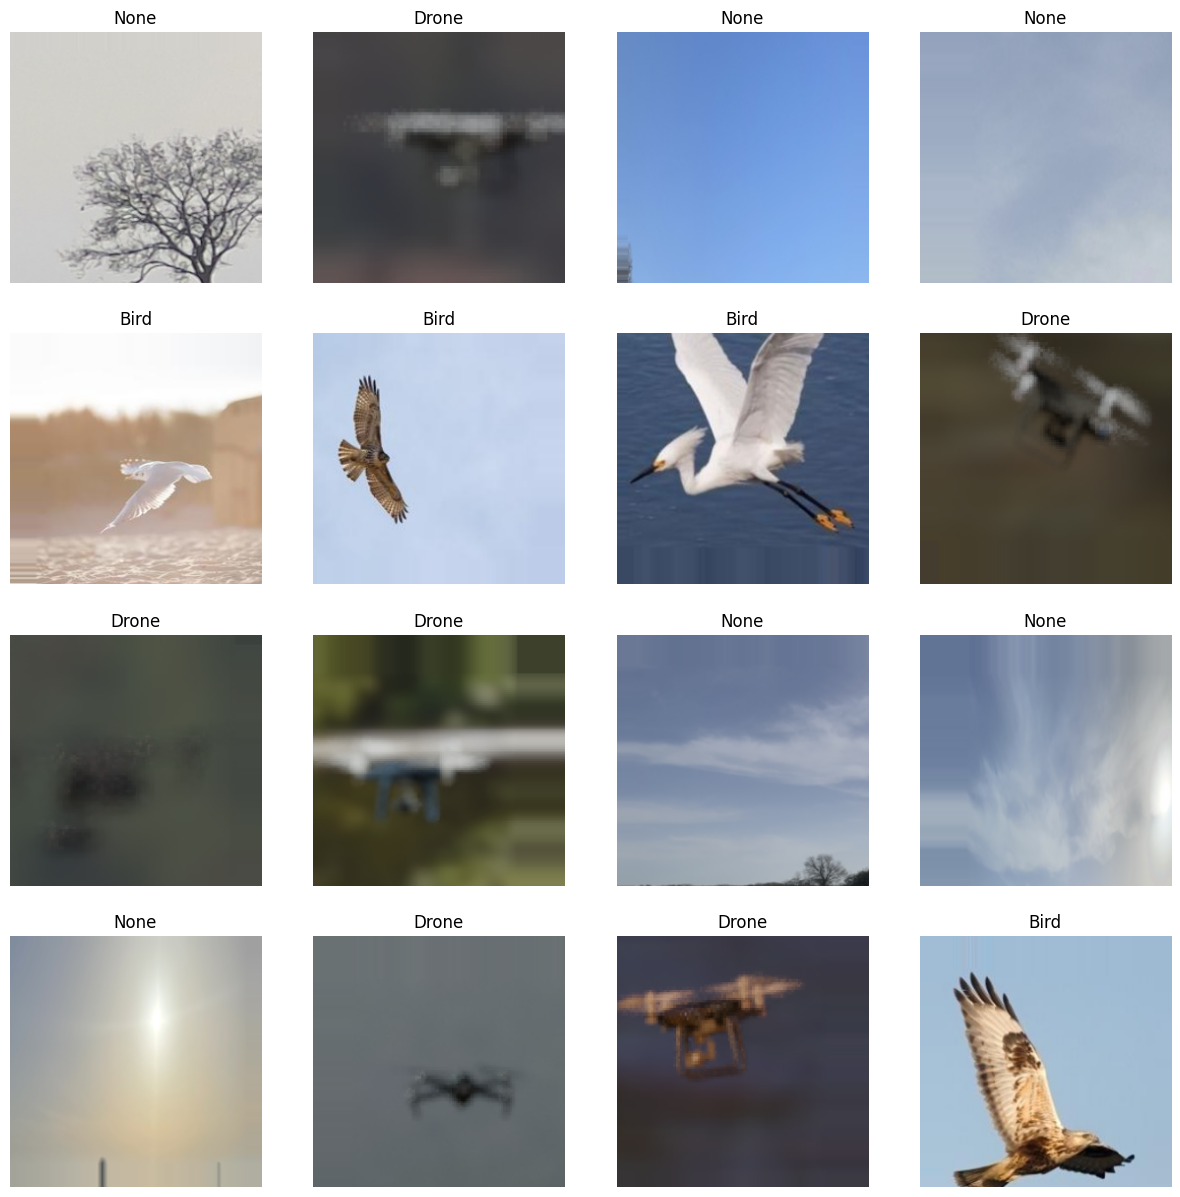

In [19]:
#이미지 예시로 16개 정도 출력
class_names = ["Bird", "Drone", "None"]
import numpy as np


plt.figure(figsize=(15,15)) #inch
images, labels = train_batch[0][:16], train_batch[1][:16]
for i in range(16):
  ax = plt.subplot(4, 4, i+1) # row, column, index
  plt.imshow(train_batch[0][i])
  plt.title(class_names[np.argmax(labels[i])])# labels[i] = [0. 0. 1.]로
  plt.axis("off")

In [20]:

def plot_loss(history):
    # 로스 그래프
  plt.subplot(2, 1, 1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'])

  # 정확도 그래프
  plt.subplot(2, 1, 2)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'])

  # 그래프 표시
  plt.tight_layout()
  plt.show()

  return 0

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 256, 256, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                     

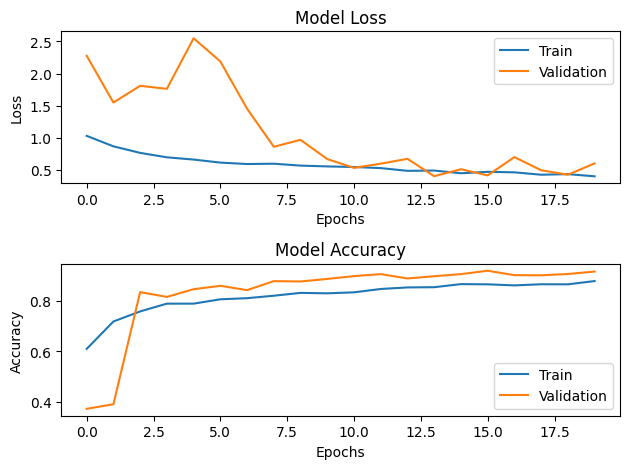

In [21]:


do_training = True
IMG_SHAPE = (256, 256, 3)
if do_training==True:

  model = EfficientNetB0(input_shape=IMG_SHAPE, include_top=True, weights=None, classes=NUM_CLASSES, 
    classifier_activation="softmax")


  opt = Adam(learning_rate=0.00001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  # EarlyStopping 콜백 정의
  early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
  # ModelCheckpoint로 10번의 에폭동안 진전 없으면 정지, 제일 높은 성능을 가진 best_model.h5파일을 저장
  checkpoint = ModelCheckpoint('C:/Users/mosfet/Desktop/vsa/effNet.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

  # 모델 학습 시 콜백 적용
  history = model.fit(train_generator, validation_data=validation_generator, epochs=EPOCHS, callbacks=[early_stopping, checkpoint])

  plot_loss(history)

else:

  model = tf.keras.models.load_model(model_dir)

In [22]:
import matplotlib.pyplot as plt
import numpy as np


def plot_test(model, test_generator):
  # test_generator의 첫 번째 배치 가져오기
  x_batch, y_batch = next(test_generator)

  # 배치에서 첫 번째 이미지 선택
  for i in range(16):
    image = x_batch[i]
    true_label =y_batch[i]

    # 모델 예측 수행
    y_pred = model.predict(np.expand_dims(image, axis=0))
    y_pred_class = np.argmax(y_pred, axis=1)[0]

    # 클래스 인덱스에서 클래스 이름으로 변환
    class_names = ["Bird", "Drone", "None"]

    true_class_name = class_names[np.argmax(true_label, axis=0)]
    predicted_class_name = class_names[y_pred_class]

    # 이미지 시각화

    plt.figure(figsize=(5,5)) #inch
    #ax = plt.subplot(4, 4, i+1) # row, column, index
    image = (image*256).astype(np.uint8)
    plt.imshow(image.astype("uint8"))
    plt.title(f'True: {true_class_name}, Predicted: {predicted_class_name}')
    plt.axis('off')
    plt.show()
    acc_dividend=y_pred[0][0]+y_pred[0][1]+y_pred[0][2]
    accuracy_0 = y_pred[0][0]/acc_dividend*100
    accuracy_1 = y_pred[0][1]/acc_dividend*100
    accuracy_2 = y_pred[0][2]/acc_dividend*100
    print("Predicted probabilities")
    print(f'Bird : {accuracy_0:.5f}%')
    print(f'Drone: {accuracy_1:.5f}%')
    print(f'None: {accuracy_2:.5f}%')
    print("\n")

    return 0


In [ ]:
# 모델 로드
model = tf.keras.models.load_model('C:/Users/mosfet/Desktop/vsa/effNet.keras')

# 모델 평가
loss, accuracy = model.evaluate(test_generator)

print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

100/100 [==============================] - 4s 29ms/step - loss: 0.3795 - accuracy: 0.9336
Test loss: 0.37947437167167664
Test accuracy: 0.9335839748382568


In [27]:
import os
import random
import shutil
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

filepath = 'C:/Users/mosfet/Desktop/vsa/effNet.keras'
test_dir = r"C:/Users/mosfet/Desktop/vsa/drone_birds_dataset/test"

model = tf.keras.models.load_model(filepath)
model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 256, 256, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                     

Found 1596 images belonging to 3 classes.
1/1 [==============================] - 1s 885ms/step


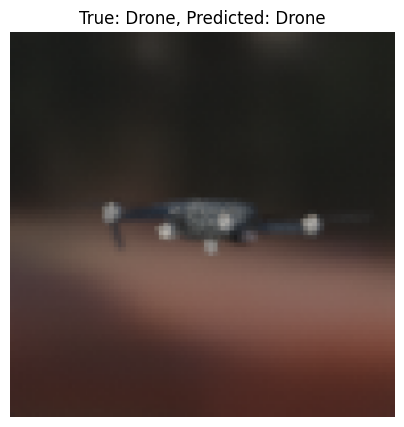

Predicted probabilities
Bird : 0.08260%
Drone: 99.52474%
None: 0.39267%


1/1 [==============================] - 0s 20ms/step


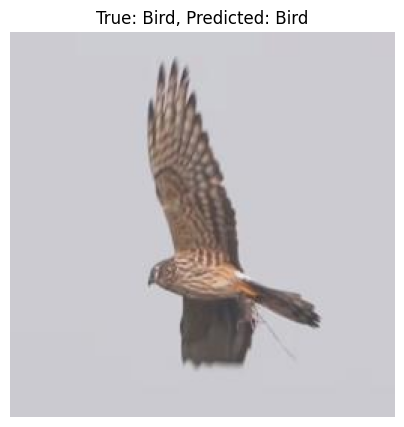

Predicted probabilities
Bird : 80.09579%
Drone: 19.67621%
None: 0.22801%


1/1 [==============================] - 0s 21ms/step


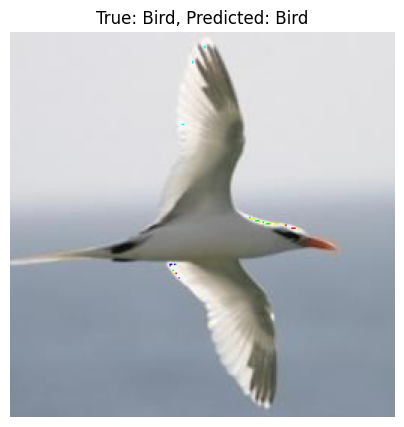

Predicted probabilities
Bird : 96.48200%
Drone: 2.27888%
None: 1.23913%


1/1 [==============================] - 0s 23ms/step


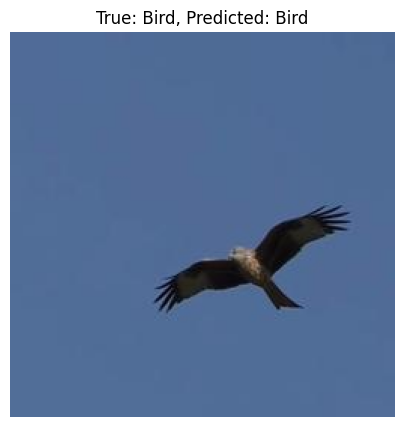

Predicted probabilities
Bird : 92.95903%
Drone: 4.85956%
None: 2.18141%


1/1 [==============================] - 0s 27ms/step


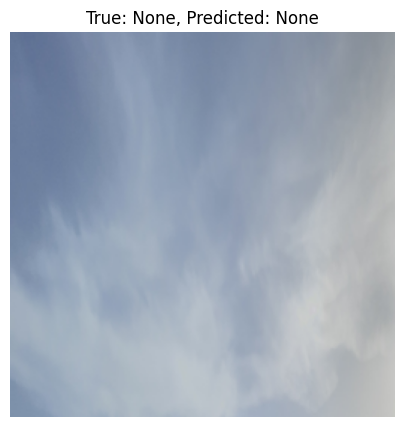

Predicted probabilities
Bird : 0.39549%
Drone: 5.17375%
None: 94.43076%


1/1 [==============================] - 0s 20ms/step


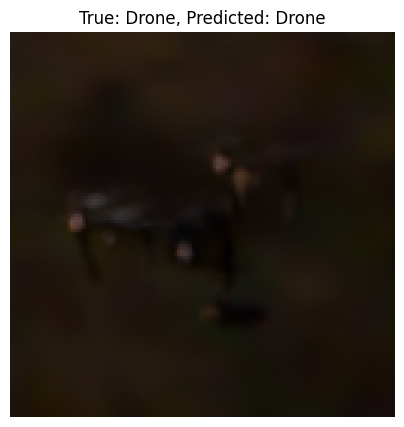

Predicted probabilities
Bird : 0.05163%
Drone: 99.90734%
None: 0.04104%


1/1 [==============================] - 0s 20ms/step


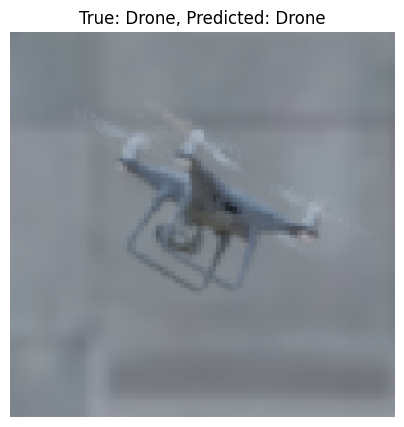

Predicted probabilities
Bird : 4.62920%
Drone: 74.81313%
None: 20.55767%


1/1 [==============================] - 0s 21ms/step


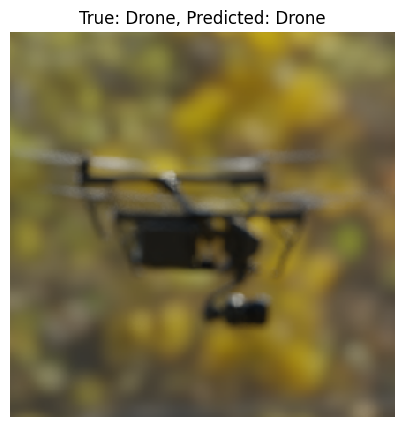

Predicted probabilities
Bird : 0.56774%
Drone: 97.62499%
None: 1.80728%




In [45]:
test_datagen = ImageDataGenerator(rescale=1. / 255.)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(256, 256), batch_size=8, shuffle=True,
                                                  class_mode='categorical')


# test_generator의 첫 번째 배치 가져오기
x_batch, y_batch = next(test_generator)

# 배치에서 첫 번째 이미지 선택
for i in range(8):
  image = x_batch[i]
  true_label = y_batch[i]

  # 모델 예측 수행
  y_pred = model.predict(np.expand_dims(image, axis=0))
  y_pred_class = np.argmax(y_pred, axis=1)[0]

  # 클래스 인덱스에서 클래스 이름으로 변환
  class_names = ["Bird", "Drone", "None"]

  true_class_name = class_names[np.argmax(true_label, axis=0)]
  predicted_class_name = class_names[y_pred_class]

  # 이미지 시각화

  plt.figure(figsize=(5,5)) #inch
  #ax = plt.subplot(4, 4, i+1) # row, column, index
  image = (image*256).astype(np.uint8)
  plt.imshow(image.astype("uint8"))
  plt.title(f'True: {true_class_name}, Predicted: {predicted_class_name}')
  plt.axis('off')
  plt.show()
  acc_dividend=y_pred[0][0]+y_pred[0][1]+y_pred[0][2]
  accuracy_0 = y_pred[0][0]/acc_dividend*100
  accuracy_1 = y_pred[0][1]/acc_dividend*100
  accuracy_2 = y_pred[0][2]/acc_dividend*100
  print("Predicted probabilities")
  print(f'Bird : {accuracy_0:.5f}%')
  print(f'Drone: {accuracy_1:.5f}%')
  print(f'None: {accuracy_2:.5f}%')
  print("\n")

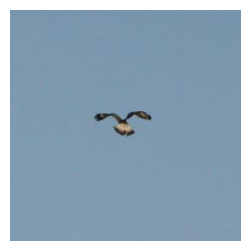

1/1 [==============================] - 1s 889ms/step
Predicted probabilities
Bird : 63.66901%
Drone: 31.13908%
None : 5.19191%




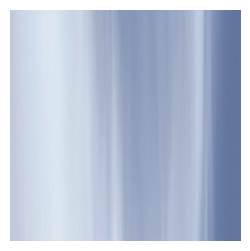

1/1 [==============================] - 0s 21ms/step
Predicted probabilities
Bird : 1.64344%
Drone: 5.06415%
None : 93.29241%




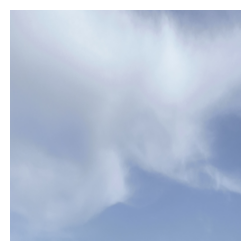

1/1 [==============================] - 0s 22ms/step
Predicted probabilities
Bird : 0.64889%
Drone: 3.49519%
None : 95.85593%




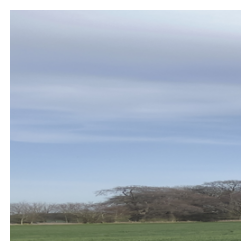

1/1 [==============================] - 0s 22ms/step
Predicted probabilities
Bird : 0.27123%
Drone: 0.25208%
None : 99.47668%




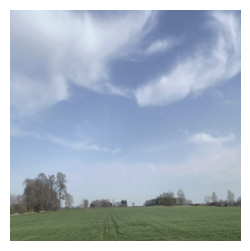

1/1 [==============================] - 0s 25ms/step
Predicted probabilities
Bird : 1.02423%
Drone: 0.31728%
None : 98.65849%




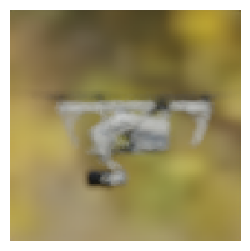

1/1 [==============================] - 0s 28ms/step
Predicted probabilities
Bird : 0.88794%
Drone: 96.86141%
None : 2.25066%




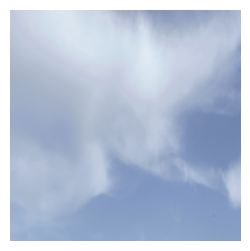

1/1 [==============================] - 0s 23ms/step
Predicted probabilities
Bird : 0.82211%
Drone: 2.82678%
None : 96.35111%




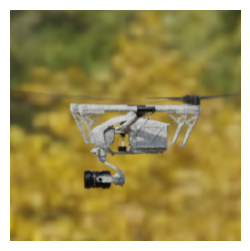

1/1 [==============================] - 0s 21ms/step
Predicted probabilities
Bird : 37.59700%
Drone: 61.69757%
None : 0.70543%




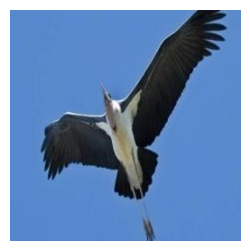

1/1 [==============================] - 0s 21ms/step
Predicted probabilities
Bird : 99.99622%
Drone: 0.00058%
None : 0.00320%




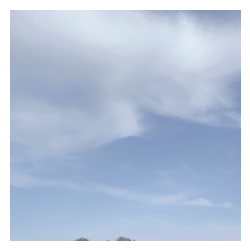

1/1 [==============================] - 0s 33ms/step
Predicted probabilities
Bird : 0.31765%
Drone: 1.15640%
None : 98.52595%




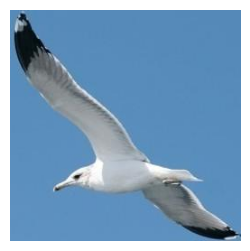

1/1 [==============================] - 0s 22ms/step
Predicted probabilities
Bird : 95.48664%
Drone: 0.33298%
None : 4.18038%




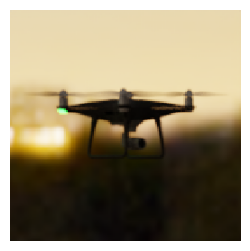

1/1 [==============================] - 0s 23ms/step
Predicted probabilities
Bird : 44.77018%
Drone: 52.88447%
None : 2.34535%




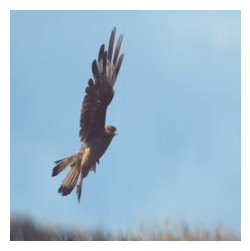

1/1 [==============================] - 0s 20ms/step
Predicted probabilities
Bird : 98.51613%
Drone: 0.68210%
None : 0.80177%




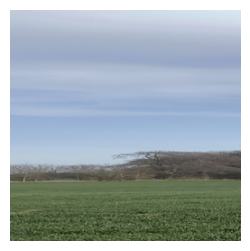

1/1 [==============================] - 0s 28ms/step
Predicted probabilities
Bird : 4.00892%
Drone: 0.71462%
None : 95.27646%




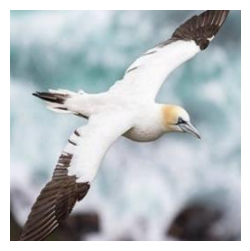

1/1 [==============================] - 0s 23ms/step
Predicted probabilities
Bird : 99.78821%
Drone: 0.16397%
None : 0.04782%




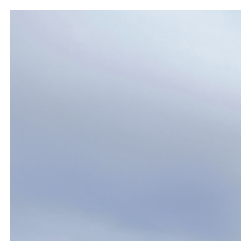

1/1 [==============================] - 0s 21ms/step
Predicted probabilities
Bird : 0.42570%
Drone: 3.51900%
None : 96.05530%




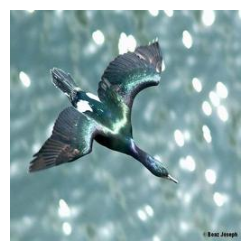

1/1 [==============================] - 0s 36ms/step
Predicted probabilities
Bird : 99.65717%
Drone: 0.00001%
None : 0.34282%




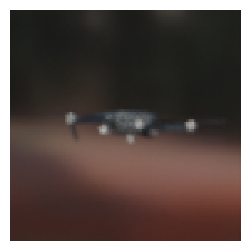

1/1 [==============================] - 0s 23ms/step
Predicted probabilities
Bird : 0.08266%
Drone: 99.52458%
None : 0.39277%




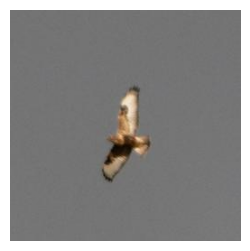

1/1 [==============================] - 0s 20ms/step
Predicted probabilities
Bird : 20.29868%
Drone: 79.13276%
None : 0.56857%




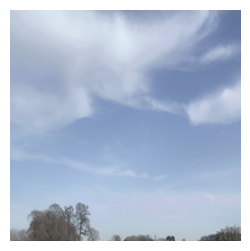

1/1 [==============================] - 0s 30ms/step
Predicted probabilities
Bird : 0.43812%
Drone: 0.31586%
None : 99.24602%




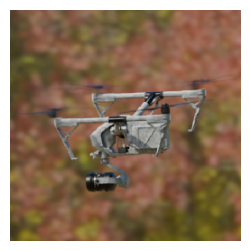

1/1 [==============================] - 0s 23ms/step
Predicted probabilities
Bird : 75.30127%
Drone: 24.40244%
None : 0.29629%




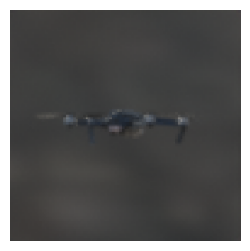

1/1 [==============================] - 0s 26ms/step
Predicted probabilities
Bird : 0.03626%
Drone: 98.94598%
None : 1.01776%




IndexError: list index out of range

In [70]:
import os
import random
import shutil
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.inception_v3 import preprocess_input


modelpath = 'C:/Users/mosfet/Desktop/vsa/effNet.keras'
incomming_dir = 'C:/Users/mosfet/Desktop/vsa/test/data/incomming'
old_dir = 'C:/Users/mosfet/Desktop/vsa/test/data/old'

model = tf.keras.models.load_model(modelpath)
idx = ["Bird", "Drone", "None"]

while(True):
#for _ in range(1):
  image_list = sorted(os.listdir(incomming_dir))
  # print(image_list)
  img = load_img(str(incomming_dir + '/' + image_list[0]), target_size=(256, 256, 3))
  img = img_to_array(img)
  img = img / 255.0
  # print(img)

  plt.figure(figsize=(3, 3))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  # 모델 예측 수행
  y_pred = model.predict(np.expand_dims(img, axis=0))
  y_pred_class = np.argmax(y_pred, axis=1)[0]
  
  # 클래스 인덱스에서 클래스 이름으로 변환
  predicted_class_name = class_names[y_pred_class]
  
  acc_dividend = y_pred[0][0] + y_pred[0][1] + y_pred[0][2]
  accuracy_0 = y_pred[0][0]/acc_dividend*100
  accuracy_1 = y_pred[0][1]/acc_dividend*100
  accuracy_2 = y_pred[0][2]/acc_dividend*100

  print("Predicted probabilities")
  print(f'Bird : {accuracy_0:.5f}%')
  print(f'Drone: {accuracy_1:.5f}%')
  print(f'None : {accuracy_2:.5f}%')
  print("\n")



  shutil.move(os.path.join(incomming_dir, image_list[0]), os.path.join(old_dir, image_list[0]))
  # time.sleep(1)
